In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
#the following code is used to restrict the usage of GPU upto half its maximum capacity
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
train_dir = r'C:\Users\Saksham Sharma\Desktop\ML Projects\dog vs cat\train'
test_dir = r'C:\Users\Saksham Sharma\Desktop\ML Projects\dog vs cat\test'
validation_dir = r'C:\Users\Saksham Sharma\Desktop\ML Projects\dog vs cat\validation'

In [5]:
#performing data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale  = 1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size = (150, 150),
                    batch_size = 32,
                    class_mode = "binary")

validation_generator = test_datagen.flow_from_directory(
                        validation_dir,
                        target_size = (150, 150),
                        batch_size = 32,
                        class_mode = "binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
#importing the transfer learning model
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = "imagenet",
                  include_top = False,  # used as we only want the convolutional base rather than the whole model
                 input_shape = (150, 150, 3))

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
#adding the final hidden layers and the output layer
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
# to freeze the conv layer:
# conv_base.trainable = False
from tensorflow.keras import optimizers

model.compile(loss = "binary_crossentropy",
              optimizer = optimizers.RMSprop(lr = 2e-5),
              metrics = ["acc"])

In [11]:
#if you wish to save your madel after each epoch
checkpoint_cb = keras.callbacks.ModelCheckpoint("CNN_project_Model - {epoch:02d}.h5")

In [12]:
history = model.fit_generator(train_generator,
                             steps_per_epoch = 100,  # (number of images / batch size)
                             epochs = 30,
                             validation_data = validation_generator,
                             validation_steps = 50,
                             callbacks = [checkpoint_cb])

Epoch 1/30
100/100 [==============================] - 80s 800ms/step - loss: 0.4528 - acc: 0.7778 - val_loss: 0.1829 - val_acc: 0.9327
Epoch 2/30
100/100 [==============================] - 63s 629ms/step - loss: 0.2390 - acc: 0.8951 - val_loss: 0.1899 - val_acc: 0.9289
Epoch 3/30
100/100 [==============================] - 63s 630ms/step - loss: 0.1810 - acc: 0.9284 - val_loss: 0.1130 - val_acc: 0.9607
Epoch 4/30
100/100 [==============================] - 63s 628ms/step - loss: 0.1526 - acc: 0.9403 - val_loss: 0.1135 - val_acc: 0.9543
Epoch 5/30
100/100 [==============================] - 63s 627ms/step - loss: 0.1210 - acc: 0.9488 - val_loss: 0.0988 - val_acc: 0.9600
Epoch 6/30
100/100 [==============================] - 63s 625ms/step - loss: 0.0987 - acc: 0.9635 - val_loss: 0.0799 - val_acc: 0.9708
Epoch 7/30
100/100 [==============================] - 63s 630ms/step - loss: 0.0869 - acc: 0.9640 - val_loss: 0.0889 - val_acc: 0.9727
Epoch 8/30
100/100 [==============================] - 6

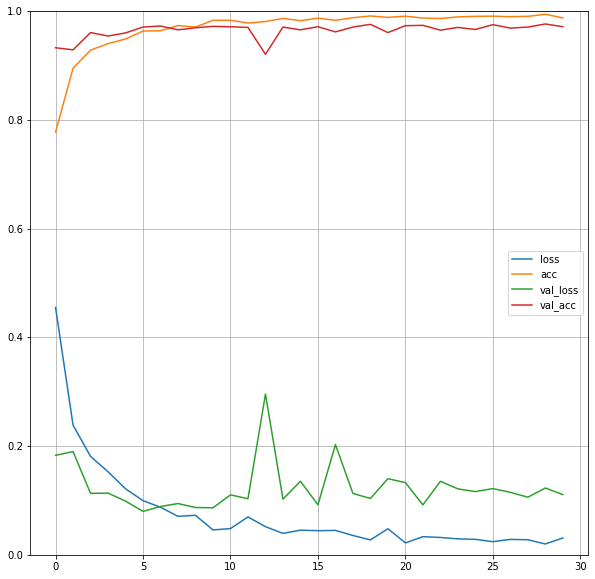

In [13]:
pd.DataFrame(history.history).plot(figsize = (10, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

As seen in the graph above, the val accuracy curve seems to reach an asymptote hence training for further epochs is less likely to help.

In [14]:
#now we save our data after each epoch traning into a csv filoe for future reference
hist_df = pd.DataFrame(history.history)

hist_csv_file = "history.csv"
with open(hist_csv_file, mode = "w") as f:
    hist_df.to_csv(f)

In [15]:
#now we evaluate our test datset
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size = (150, 150),
            batch_size = 20,
            class_mode = "binary")

model.evaluate_generator(test_generator, steps = 50)

Found 1000 images belonging to 2 classes.


[0.17738609860189172, 0.964]

Hence our final test accuracy comes out to be 96.4%